In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from itertools import permutations
import pmdarima as pm

import warnings
warnings.filterwarnings('ignore')

#**Import Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_customer = pd.read_csv(r'/content/drive/MyDrive/PBI Kalbe Nutritionals/Case Study - Customer.csv', delimiter=';')
df_product = pd.read_csv(r'/content/drive/MyDrive/PBI Kalbe Nutritionals/Case Study - Product.csv', delimiter=';')
df_store = pd.read_csv(r'/content/drive/MyDrive/PBI Kalbe Nutritionals/Case Study - Store.csv', delimiter=';')
df_transaction = pd.read_csv(r'/content/drive/MyDrive/PBI Kalbe Nutritionals/Case Study - Transaction.csv', delimiter=';')

#**Data Cleaning**

In [ ]:
df_customer.shape, df_product.shape, df_store.shape, df_transaction.shape

((447, 5), (10, 3), (14, 6), (5020, 8))

In [ ]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


In [ ]:
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


In [ ]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     object
 5   Longitude   14 non-null     object
dtypes: int64(1), object(5)
memory usage: 800.0+ bytes


In [ ]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


Observasi:
- Terdapat data Null pada fetures Marital Status
- Data type terdiri atas object dan int4

In [ ]:
df_customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [ ]:
df_product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [ ]:
df_store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"


In [ ]:
df_transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


Observasi:
- Data pada feature Income, latitude dan longitude masih dengan koma, seharusnya titik

In [ ]:
#Data cleaning pada df_customer
df_customer['Income'] = df_customer['Income'].replace('[,]','.', regex=True).astype('float')

In [ ]:
#Data cleaning pada df_store
df_store['Latitude'] = df_store['Latitude'].replace('[,]','.', regex=True).astype('float')
df_store['Longitude'] = df_store['Longitude'].replace('[,]','.', regex=True).astype('float')

In [ ]:
#Data cleaning pada df_transaction
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'])

In [ ]:
#Data cleaning Menghapus baris Null pada Marital Status
df_customer.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64

In [ ]:
df_customer = df_customer.dropna(subset=['Marital Status'])

In [ ]:
df_customer.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    0
Income            0
dtype: int64

#**Merge Data**

In [ ]:
df_merge = pd.merge(df_transaction, df_customer, on=['CustomerID'])
df_merge = pd.merge(df_merge, df_product.drop(columns=['Price']), on=['ProductID'])
df_merge = pd.merge(df_merge, df_store, on=['StoreID'])

In [ ]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


#**Model Machine Learning Regresi (Time Series) ARIMA**

In [ ]:
#Forecast data
df_fore = df_merge[['Date','Qty']]
df_fore= df_fore.groupby('Date')[['Qty']].sum()
df_fore.head(3)

,Qty
Date,
2022-01-01,49
2022-01-02,50
2022-01-03,76


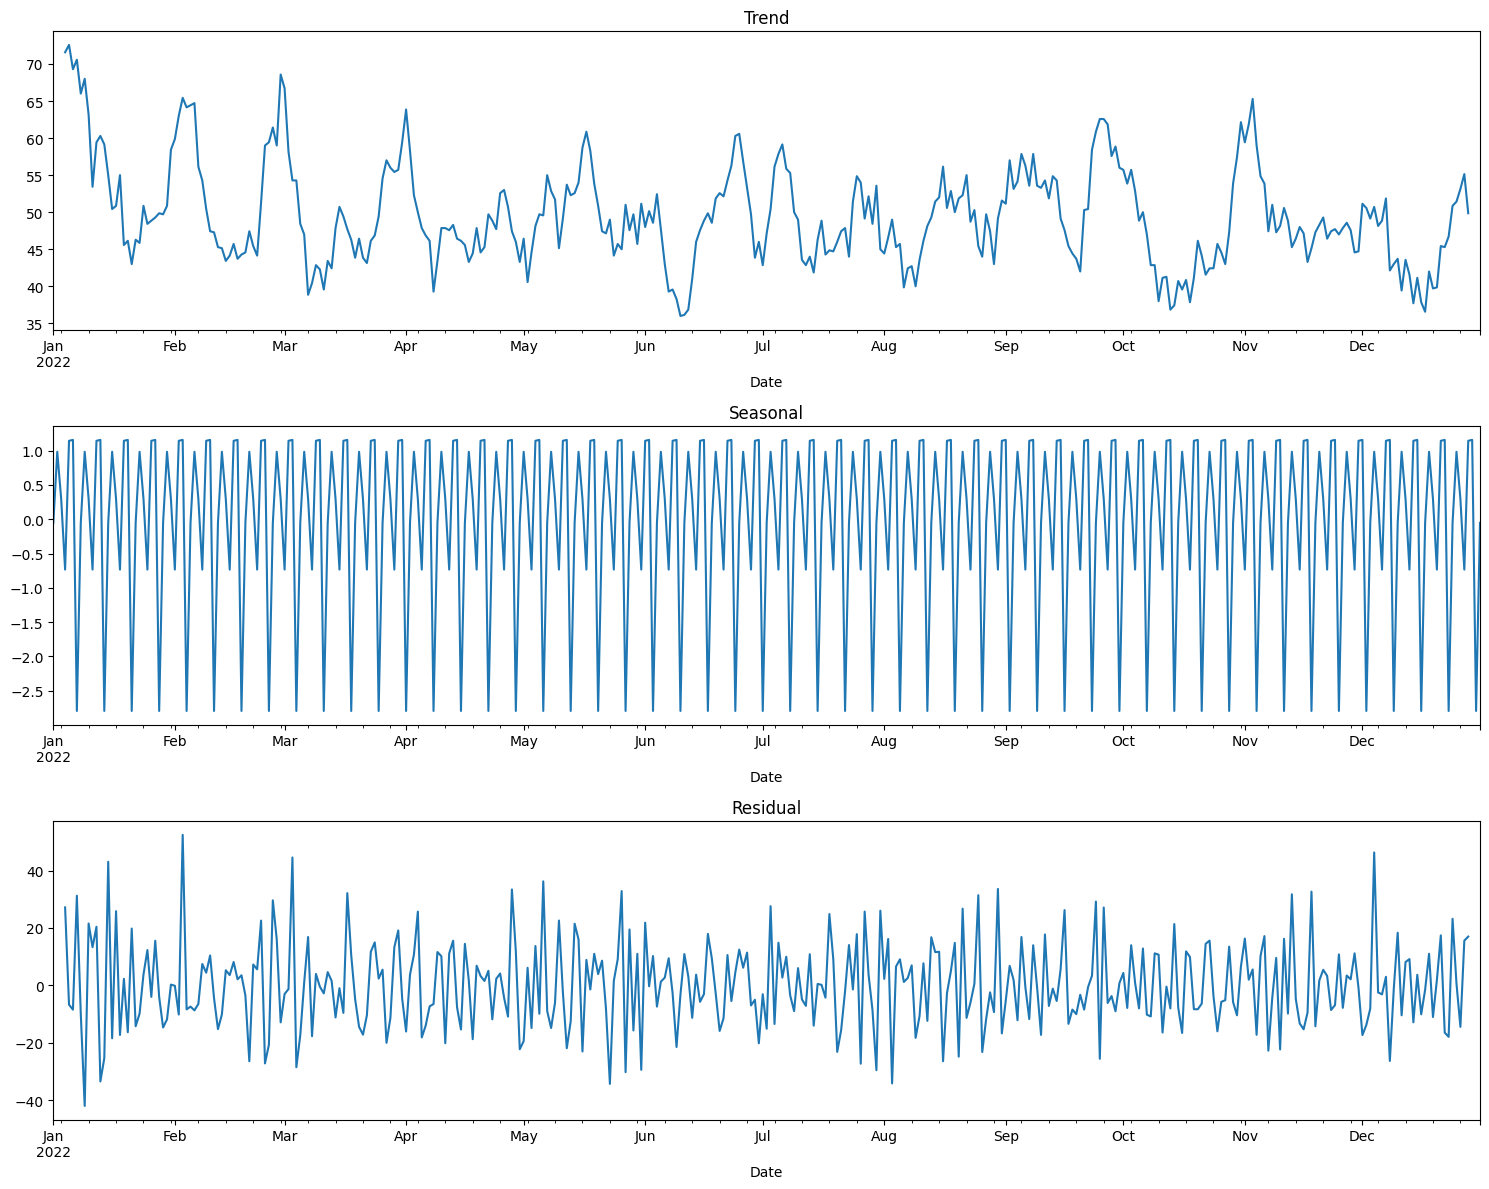

In [ ]:
decompose = seasonal_decompose(df_fore)

fig,ax = plt.subplots(3,1,figsize=(15,12))
decompose.trend.plot(ax=ax[0])
ax[0].set_title('Trend')
decompose.seasonal.plot(ax=ax[1])
ax[1].set_title('Seasonal')
decompose.resid.plot(ax=ax[2])
ax[2].set_title('Residual')

plt.tight_layout()
plt.show()

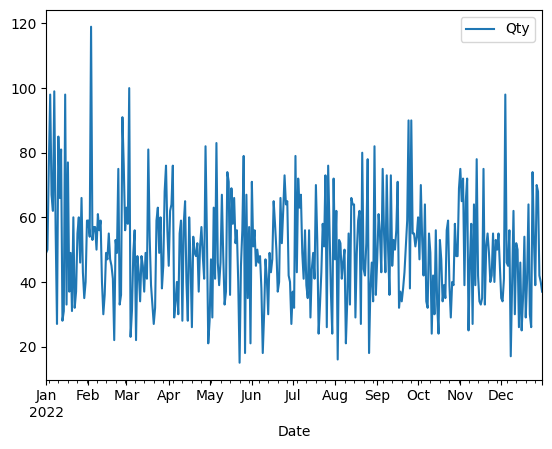

In [ ]:
df_fore.plot()
plt.show()

#**Data Transformation**

In [ ]:
#Transform data to log
df_fore = np.log(df_fore)
df_fore.head(3)

,Qty
Date,
2022-01-01,3.891820
2022-01-02,3.912023
2022-01-03,4.330733


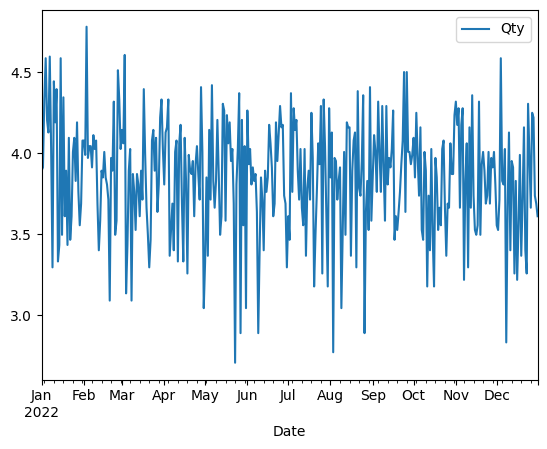

In [ ]:
df_fore.plot()
plt.show()

#**Split Data**

In [ ]:
#Split train and test
df_train = df_fore.iloc[:-31]
df_test = df_fore.iloc[-31:]

#**Check Stationary Data**

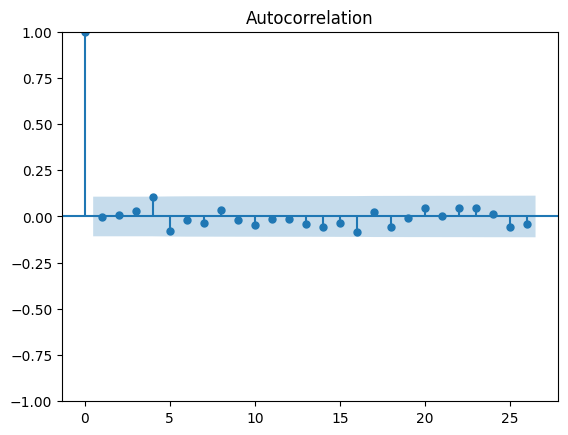

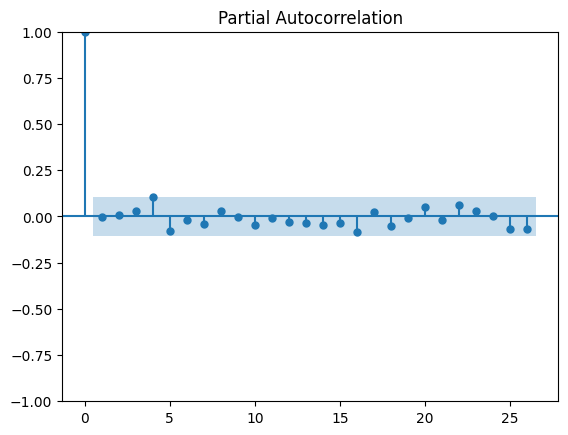

In [ ]:
#Plot ACF and PACF
acf_original = plot_acf(df_train)
pacf_original = plot_pacf(df_train)

In [ ]:
#ADF test
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')

p-value: 2.308849689470346e-30


**Observasi:**
- Dari ADF Test kita dapat melihat bahwa nilai p lebih dari 0,05 yang berarti hipotesis nol kita akan ditolak dan deret ini dianggap sudah stasioner.
- Dari plot ACF dan PACF, data tersebut sudah stationary dan bisa digunakan untuk ARIMA model.

#**Model ARIMA**

 2 metode untuk mendapatkan parameter (p,d,q) untuk menghasilkan forecast yang akurat yaitu dengan melakukan auto-fit ARIMA dan manual parameter tuning

##Modelling & Evaluation

In [ ]:
#auto-fit ARIMA
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(1, 0, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
#Manual parameter tuning
def tune(z,y,x):
    model = ARIMA(df_train, order=(x,y,z))
    model_fit = model.fit()
    forecast_test = model_fit.forecast(len(df_test))
    df_plot = df_fore[['Qty']].iloc[-61:]

    df_plot['forecast'] = [None]*(len(df_plot)-len(forecast_test)) + list(forecast_test)

    mae = mean_absolute_error(df_test, forecast_test)
    mape = mean_absolute_percentage_error(df_test, forecast_test)
    rmse = np.sqrt(mean_squared_error(df_test, forecast_test))

    return mae,mape,rmse

#Parameter combinations
pval = [50,60,70]
dval = [2]
qval = [1]

comb = []
for i in pval:
    for j in dval:
        for k in qval:
            comb.append((i,j,k))

param = []
mae_score = []
mape_score = []
rmse_score = []

for i in comb:
    param.append(i)
    score = tune(*i)
    mae_score.append(score[0])
    mape_score.append(score[1])
    rmse_score.append(score[2])

tuning_df = pd.DataFrame({'param':param,'mae':mae_score,'mape':mape_score,'rsme':rmse_score})
tuning_df.sort_values(by='mae').head(3)

,param,mae,mape,rsme
2,"(70, 2, 1)",0.309134,0.082776,0.395608
1,"(60, 2, 1)",0.328327,0.088083,0.415141
0,"(50, 2, 1)",0.380785,0.105433,0.455044


In [ ]:
#Manual parameter tuning
model = ARIMA(df_train, order=(70, 2, 1))
model_fit = model.fit()

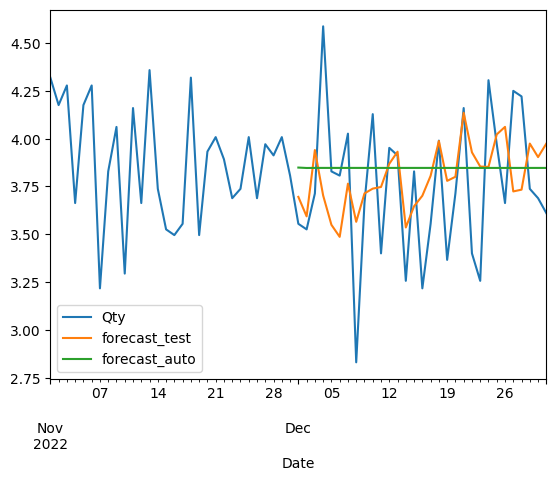

In [ ]:
#plot forecasting
forecast_test = model_fit.forecast(len(df_test))
forecast_auto = auto_arima.predict(len(df_test))

df_plot = df_fore[['Qty']].iloc[-61:]

df_plot['forecast_test'] = [None]*(len(df_plot)-len(forecast_test)) + list(forecast_test)
df_plot['forecast_auto'] = [None]*(len(df_plot)-len(forecast_auto)) + list(forecast_auto)

df_plot.plot()
plt.show()

In [ ]:
#Manual parameter tuning metrics

mae = mean_absolute_error(df_test, forecast_test)
mape = mean_absolute_percentage_error(df_test, forecast_test)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test))

print(f'mae - manual: {round(mae,4)}')
print(f'mape - manual: {round(mape,4)}')
print(f'rmse - manual: {round(rmse,4)}')

mae - manual: 0.3019
mape - manual: 0.0825
rmse - manual: 0.37


In [ ]:
#Auto-fit ARIMA metrics

mae = mean_absolute_error(df_test, forecast_auto)
mape = mean_absolute_percentage_error(df_test, forecast_auto)
rmse = np.sqrt(mean_squared_error(df_test, forecast_auto))

print(f'mae - auto: {round(mae,4)}')
print(f'mape - auto: {round(mape,4)}')
print(f'rmse - auto: {round(rmse,4)}')

mae - auto: 0.3059
mape - auto: 0.0855
rmse - auto: 0.3821


**Observasi:**

Dari metric diatas kita akan pilih ARIMA model dengan parameter (70,2,1)

#**Forecasting Overall Quantity**

In [ ]:
#Apply model to forecast data
model = ARIMA(df_fore, order=(70, 2, 1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=30)

In [ ]:
#Re-trasnform data
df_fore = np.exp(df_fore)
forecast = np.exp(forecast)

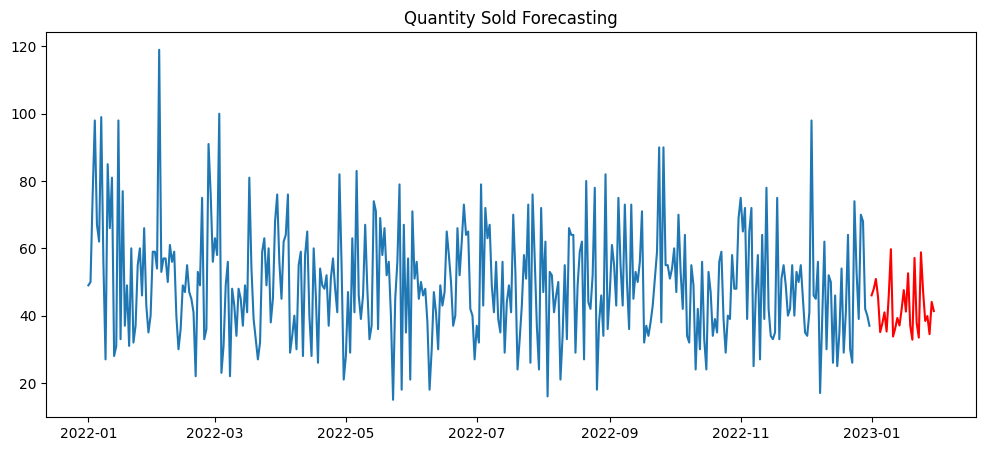

In [ ]:
#Plot forecasting
plt.figure(figsize=(12,5))
plt.plot(df_fore)
plt.plot(forecast,color='red')
plt.title('Quantity Sold Forecasting')
plt.show()

In [ ]:
forecast.mean()

42.57925225656516

**Observasi:**

Dari forecasting di atas dapat disimpulkan bahwa untuk quantity penjualan bulan depan adalah sekitar rata-rata 43 pcs per harinya.

#**Forecasting Each Product**

In [ ]:
df_merge.head(5)

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


In [ ]:
#Forecast for next 30 days for each product
list_prod = df_merge['Product Name'].unique()

dfp = pd.DataFrame({'Date':pd.date_range(start='2023-01-01',end='2023-01-30')})
dfp = dfp.set_index('Date')
for i in list_prod:
    df_ = df_merge[['Date','Product Name','Qty']]
    df_ = df_[df_['Product Name']==i]
    df_= df_.groupby('Date')[['Qty']].sum()
    df_ = df_.reset_index()

    df_t = pd.DataFrame({'Date':pd.date_range(start='2022-01-01',end='2022-12-31')})
    df_t = df_t.merge(df_,how='left',on='Date')
    df_t = df_t.fillna(0)
    df_t = df_t.set_index('Date')

    model1 = ARIMA(df_t, order=(70, 2, 1))
    model_fit1 = model1.fit()
    forecast1 = model_fit1.forecast(steps=30)
    dfp[i] = forecast1.values

dfp.head()

,Crackers,Oat,Thai Tea,Choco Bar,Coffee Candy,Yoghurt,Ginger Candy,Cheese Stick,Cashew,Potato Chip
Date,,,,,,,,,,
2023-01-01,4.815378,2.150630,6.270454,2.279917,4.732869,4.149178,4.027408,9.116343,1.676450,4.460086
2023-01-02,4.827093,3.290852,4.212913,3.885950,3.003851,5.508365,5.762985,1.273097,2.434337,4.580687
2023-01-03,3.540764,2.640321,9.368133,5.967222,5.189733,5.018286,5.152050,3.132939,2.756169,3.773115
2023-01-04,2.216941,2.582620,6.045998,3.713760,5.479918,4.996291,1.679349,9.194390,2.613255,4.302305
2023-01-05,4.025989,1.131011,4.460653,-4.921889,7.482708,4.490592,6.638505,5.543828,1.553065,3.525395


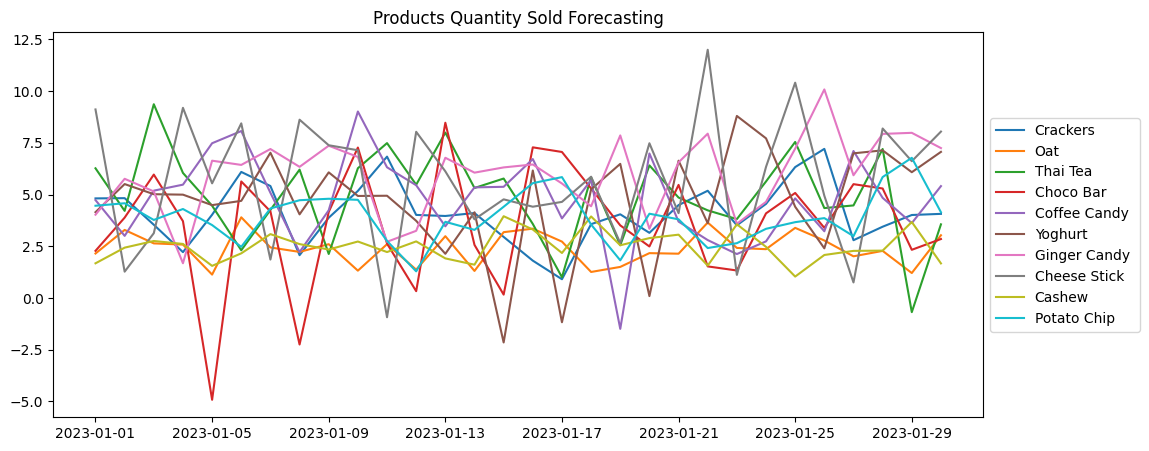

In [ ]:
#Plot forecasting
plt.figure(figsize=(12,5))
# plt.plot(df_t)
plt.plot(dfp)
plt.legend(dfp.columns,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Products Quantity Sold Forecasting')
plt.show()

In [ ]:
#Products Quantity forecast
round(dfp.describe().T['mean'],0)

Crackers         4.0
Oat              2.0
Thai Tea         5.0
Choco Bar        4.0
Coffee Candy     5.0
Yoghurt          5.0
Ginger Candy     6.0
Cheese Stick     6.0
Cashew           2.0
Potato Chip      4.0
Name: mean, dtype: float64

**Observasi:**

Dari data forecasting product di atas kita bisa mendapatkan perkiraan rata-rata quantity produk yang terjual tiap harinya.

#**Clustering**

In [ ]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


In [ ]:
#identifikasi kolom yang berkorelasi tinggi/redundant
df_merge.corr()

,CustomerID,Price,Qty,TotalAmount,StoreID,Age,Gender,Income,Latitude,Longitude
CustomerID,1.000000,-0.014821,-0.012024,-0.025266,0.005470,-0.021120,-0.015863,0.005440,0.005166,-0.004492
Price,-0.014821,1.000000,-0.354614,0.440046,-0.031782,0.013781,0.012132,0.000636,-0.027438,0.017238
Qty,-0.012024,-0.354614,1.000000,0.620804,0.012169,-0.026745,-0.011920,-0.027724,-0.007179,0.006805
TotalAmount,-0.025266,0.440046,0.620804,1.000000,-0.011283,-0.016458,-0.009479,-0.024816,-0.030704,0.026535
StoreID,0.005470,-0.031782,0.012169,-0.011283,1.000000,-0.004783,0.000449,0.000739,0.471039,-0.095710
Age,-0.021120,0.013781,-0.026745,-0.016458,-0.004783,1.000000,-0.026879,0.485532,0.009474,0.015670
Gender,-0.015863,0.012132,-0.011920,-0.009479,0.000449,-0.026879,1.000000,-0.067612,-0.006624,-0.001018
Income,0.005440,0.000636,-0.027724,-0.024816,0.000739,0.485532,-0.067612,1.000000,0.016401,0.003471
Latitude,0.005166,-0.027438,-0.007179,-0.030704,0.471039,0.009474,-0.006624,0.016401,1.000000,-0.396128
Longitude,-0.004492,0.017238,0.006805,0.026535,-0.095710,0.015670,-0.001018,0.003471,-0.396128,1.000000


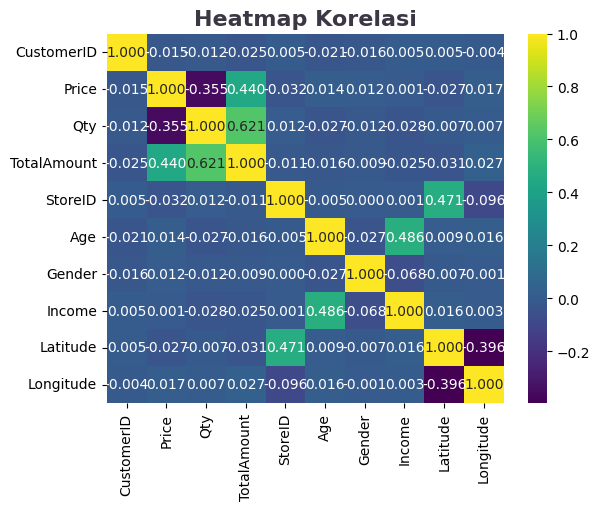

In [ ]:
plt.title('Heatmap Korelasi', color='#3C3744', fontsize=16, fontweight='bold', y=1)
sns.heatmap(df_merge.corr(), cmap='viridis', annot=True, fmt='.3f')
plt.show()

In [ ]:
df_cluster = df_merge.groupby(['CustomerID']).agg({
    'TransactionID' : 'count',
    'Qty' : 'sum',
    'TotalAmount' : 'sum'
}).reset_index()

In [ ]:
df_cluster.head()

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600


#**Normalization Data**

In [ ]:
data_cluster = df_cluster.drop(columns=['CustomerID'])

data_cluster_normalize = preprocessing.normalize(data_cluster)

#**Elbow Method of K-Means Clustering**

In [ ]:
K = range(2, 8)
fits = []
score = []

for k in K:
  model = KMeans(n_clusters = k, random_state=0, n_init='auto').fit(data_cluster_normalize)

  fits.append(model)

  score.append(silhouette_score(data_cluster_normalize, model.labels_, metric='euclidean'))

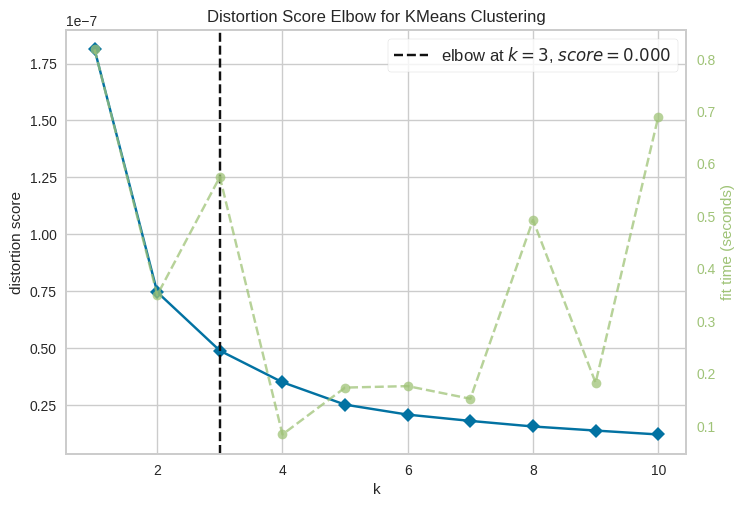

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# visualisasi innertia vs k dengan parameter distortion
from yellowbrick.cluster import KElbowVisualizer

# fit model
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(1,11), metric='distortion', timings=True, locate_elbow=True)
visualizer.fit(data_cluster_normalize)
visualizer.show()

###Observasi:
Berdasarkan grafik diatas, parameter distortion menunjukkan nilai optimal k = 3.

#**Silhouette Score**

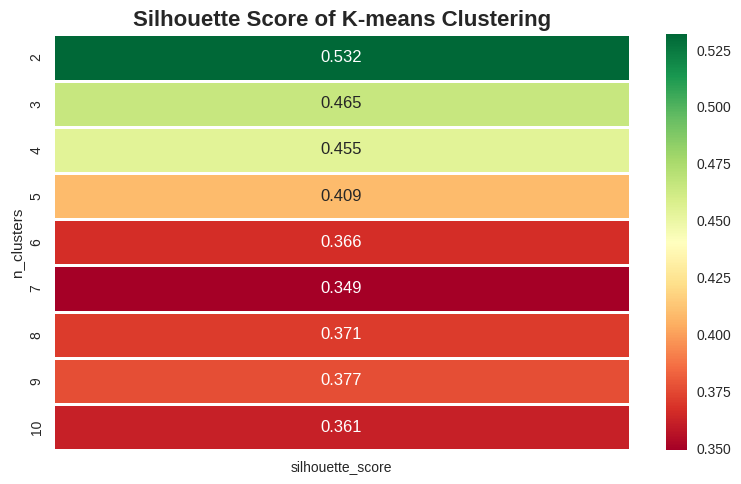

In [ ]:
from sklearn.metrics import silhouette_score

def visualize_silhouette_layer(data):
    clusters_range = range(2, 11)
    results = []

    for i in clusters_range:
        km = KMeans(n_clusters=i, random_state=142)
        cluster_labels = km.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=['n_clusters', 'silhouette_score'])
    pivot_km = pd.pivot_table(result, index='n_clusters', values='silhouette_score')

    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot_km, annot=True, linewidths=1, fmt='.3f', cmap='RdYlGn')
    plt.title('Silhouette Score of K-means Clustering', fontsize=16, fontweight='bold')
    plt.tight_layout()

visualize_silhouette_layer(data_cluster_normalize)

#**K-Means Clustering**

In [ ]:
fits[1]

KMeans(n_clusters=3, n_init='auto', random_state=0)

In [ ]:
df_cluster['cluster_label'] = fits[1].labels_

In [ ]:
df_cluster.head()

,CustomerID,TransactionID,Qty,TotalAmount,cluster_label
0,1,17,60,623300,2
1,2,13,57,392300,1
2,3,15,56,446200,0
3,4,10,46,302500,1
4,5,7,27,268600,2


In [ ]:
df_cluster.groupby(['cluster_label']).agg({
    'CustomerID' : 'count',
    'TransactionID' : 'mean',
    'Qty' : 'mean',
    'TotalAmount': 'mean'
}).reset_index()

,cluster_label,CustomerID,TransactionID,Qty,TotalAmount
0,0,179,11.005587,41.346369,338749.720670
1,1,61,10.344262,39.229508,268652.459016
2,2,204,11.642157,40.838235,409532.843137


#**Visualisasi with PCA**

In [ ]:
## melakukan PCA untuk melihat visualisasi
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

pca.fit(df_cluster)
pcs = pca.transform(df_cluster)


df_pca = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2','PC 3'])
df_pca['cluster_label'] = df_cluster['cluster_label']
df_pca

,PC 1,PC 2,PC 3,cluster_label
0,261658.808438,-192.377429,-4.704091,2
1,30658.810527,-218.009913,13.486571,1
2,84558.809762,-210.796071,7.852819,0
3,-59141.189783,-226.370717,10.628891,1
4,-93041.191333,-229.293398,-5.434181,2
...,...,...,...,...
439,-92241.240699,207.808368,4.986669,1
440,216058.758051,245.367565,1.340717,2
441,225558.758378,247.467463,6.552567,0
442,61658.757544,229.551937,-4.916544,2


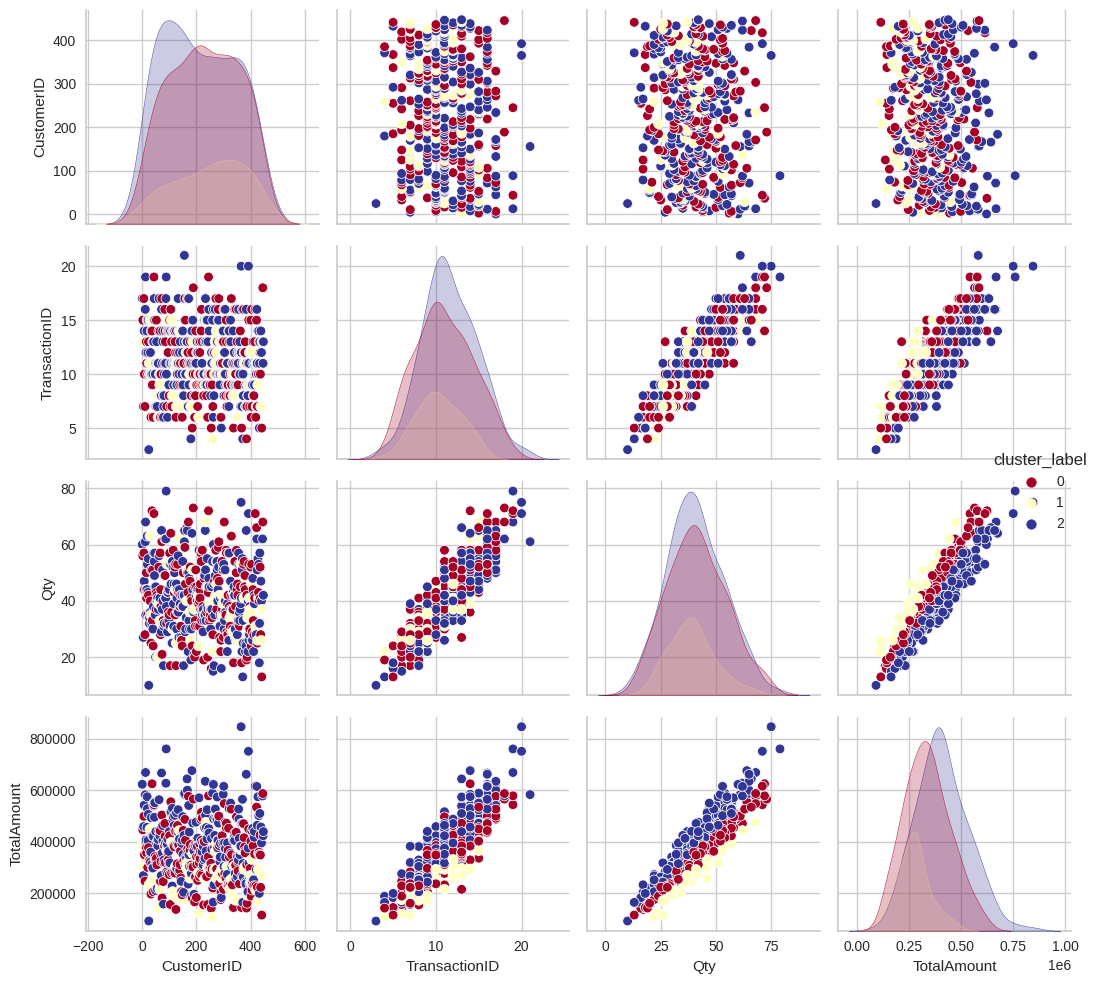

In [ ]:
# visualisasi dengan pairplot
sns.pairplot(data=df_cluster, hue='cluster_label', diag_kind='kde', palette='RdYlBu')
plt.tight_layout()

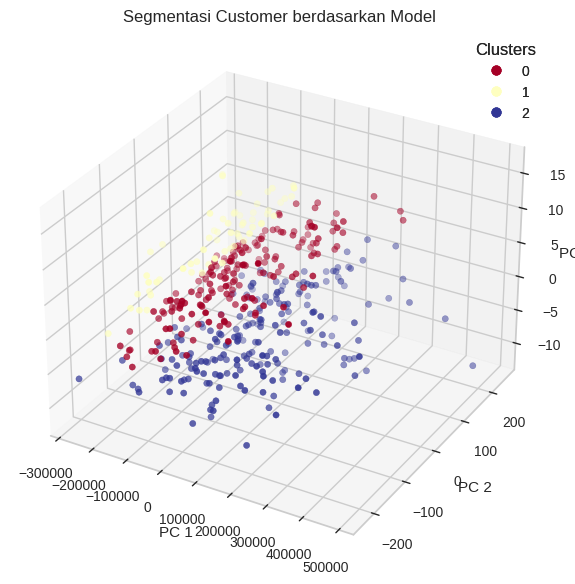

In [ ]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df_pca['PC 1'],
    df_pca['PC 2'],
    df_pca['PC 3'],
    c=df_pca['cluster_label'],
    cmap='RdYlBu'
)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Segmentasi Customer berdasarkan Model')

# Menambahkan colorbar
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

plt.show()

#**Segmentation Customer Analysis**

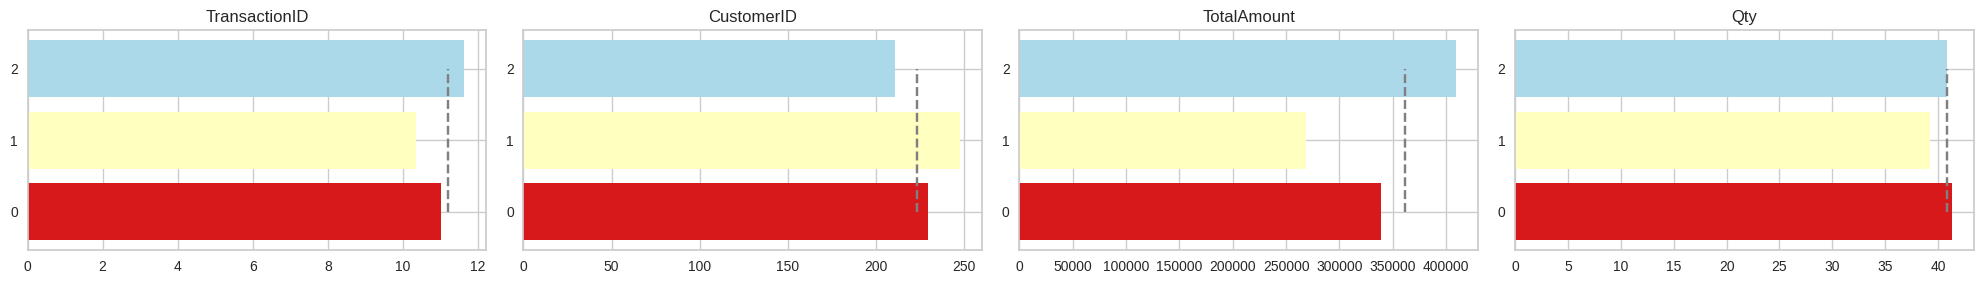

In [ ]:
#Melihat rata-rata features antar cluster
c = ['#d7191c', '#ffffbf', '#abd9e9']
df_feats = ['TransactionID', 'CustomerID', 'TotalAmount','Qty']

def dist_list(lst):
    plt.figure(figsize=[len(lst)*5, 3])
    i = 1
    for col in lst:
        ax = plt.subplot(1, len(lst), i)
        ax.vlines(df_cluster[col].mean(), ymin=0, ymax=2, color='grey', linestyle='--')
        g = df_cluster.groupby('cluster_label')
        x = g[col].mean().index
        y = g[col].mean().values
        ax.barh(x, y, color=c)
        plt.title(col)
        ax.set_yticks(x)
        ax.set_yticklabels(x)
        i = i + 1

dist_list(df_feats)
plt.tight_layout()
plt.show()

##**Characteristic Customer:**
**1. Cluster 0 (Loyalist Customer):**
- Jumlah transaksi stabil, jumlah customer cukup banyak, total belanja yang dikeluarkan cukup besar dan paling banyak berbelanja produk kalbe.

**2. Cluster 1 (New Customer):**
- Jumlah transaksi sedikit, jumlah customer paling banyak, total belanja yang dikeluarkan sangat sedikit dan kurang berbelanja produk kalbe dibandingkan kelompok lain.

**3. Cluster 2 (Potential Loyalist):**
- Jumlah transaksi paling banyak, jumlah customer paling sedikit, total belanja yang dikeluarkan sangat besar, cukup banyak berbelanja produk kalbe.


##**Business Recommendation:**

**1. Cluster 0 (Loyalist Customer):**
- Program Loyalty: Tingkatkan loyalitas pelanggan dengan mengembangkan program loyalitas yang memberikan insentif kepada pelanggan setia. Ini bisa berupa diskon khusus, hadiah, atau penawaran eksklusif untuk pelanggan dalam cluster ini.

- Ekspansi Produk: Tawarkan lebih banyak produk Kalbe yang relevan kepada pelanggan dalam cluster ini. Mungkin ada produk baru yang dapat menarik minat mereka, atau variasi produk yang dapat meningkatkan nilai belanja mereka.

- Pelayanan Pelanggan Terbaik: Pastikan pelayanan pelanggan yang sangat baik, seperti layanan pengiriman cepat dan responsif terhadap pertanyaan dan masalah pelanggan, untuk mempertahankan pelanggan dalam cluster ini.

**2. Cluster 1 (New Customer):**

- Program Pemasaran Target: Gunakan strategi pemasaran yang ditargetkan untuk meningkatkan kesadaran tentang produk Kalbe di antara pelanggan dalam cluster ini. Ini bisa mencakup kampanye iklan online, konten sosial media, atau promosi khusus.

- Penawaran Khusus untuk Pelanggan Baru: Tawarkan penawaran khusus, diskon, atau paket bundel produk kepada pelanggan baru untuk mendorong mereka untuk melakukan lebih banyak transaksi.

- Program Penghargaan untuk Mengundang Teman: Buat program referensi di mana pelanggan dalam cluster ini dapat mendapatkan insentif jika mereka mengundang teman-teman mereka untuk berbelanja produk Kalbe.

**3. Cluster 2 (Potential Loyalist):**

- Fokus pada Retensi: Meskipun jumlah pelanggan dalam cluster ini sedikit, mereka memiliki potensi besar untuk menjadi pelanggan setia. Berfokus pada mempertahankan dan meningkatkan kepuasan pelanggan dalam cluster ini.

- Program Eksklusif: Tawarkan program eksklusif seperti keanggotaan premium yang memberikan manfaat khusus kepada pelanggan dalam cluster ini, seperti akses terhadap produk terbaru atau penawaran eksklusif.

- Up-selling dan Cross-selling: Identifikasi produk-produk Kalbe yang paling diminati oleh pelanggan dalam cluster ini dan tawarkan produk-produk terkait atau produk-produk dengan nilai tambah yang lebih tinggi.
